In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

from tensorflow.keras import Model
from tensorflow.keras import metrics
from tensorflow.keras import Input
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import SGD

from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from lib.pyimagesearch import LearningRateFinder
from lib.clr_callback import CyclicLR

In [3]:
dfAll = pd.read_csv('../Data/AllHeuristics.csv', encoding = 'utf-8', lineterminator="\n")
dfTrain = pd.read_csv('../Data/train.csv', encoding = 'utf-8', lineterminator="\n")

In [4]:
dfAll = dfAll.drop(['Unnamed: 0'], axis = 1)
dfAll = dfAll.drop(['Index'], axis = 1)

In [5]:
columns = list(dfAll.columns)

In [6]:
targets = dfTrain['target']

In [7]:
col_pre = ColumnTransformer([
        ("scaler", StandardScaler(), columns)],
        remainder="passthrough")

In [8]:
dfAll.shape

(2834, 22)

In [41]:
inputs = Input(shape=(22,))
x = Rescaling(scale=1./255)(inputs)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
outputs = Dense(1, activation="linear")(x)

reg_model = Model(inputs, outputs)

reg_model.compile(optimizer=SGD(learning_rate=0.0001), loss="mse", metrics=[metrics.MeanAbsoluteError(name='MAE')])

In [42]:
history = reg_model.fit(dfAll, targets, epochs=60, batch_size=32, 
                                verbose=0, validation_split=0.20)
history.history["loss"][-1], history.history["val_loss"][-1], history.history['MAE'][-1]

(1.331992745399475, 0.8447700142860413, 0.8861608505249023)

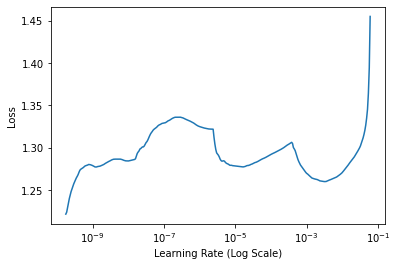

In [43]:
lr_finder = LearningRateFinder(reg_model)

lr_finder.find(trainData=(dfAll, targets), 
               startLR=1e-10, endLR=1e+1, 
               epochs=5, batchSize=32, verbose=0)

lr_finder.plot_loss(skipBegin=10, skipEnd=1, title="")

In [47]:
batch_size = 32
step_size = 6 * dfAll.shape[0] // 32

clr = CyclicLR(base_lr=10e-3, max_lr=5e-3, step_size=step_size)

history = reg_model.fit(dfAll, targets, epochs=50, batch_size=batch_size, validation_split=0.2, 
                          callbacks=[clr], verbose=0)

<AxesSubplot:>

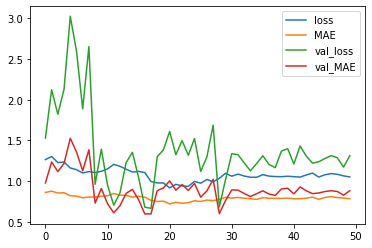

In [48]:
pd.DataFrame(history.history).plot()

In [49]:
history.history['MAE'][-1]

0.7853789925575256